In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib as plt
import matplotlib.pyplot as  plt
import numpy as np
import statsmodels as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as sgr
from matplotlib.pylab import rcParams
from pandas.core import datetools
import warnings
%matplotlib inline

data_filename = 'C:/Users/User/Desktop/Practical_DS_Leon/Assign_3/data/wowcointotal.csv'
df = pd.read_csv(data_filename)

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<img src="https://pre00.deviantart.net/109e/th/pre/i/2015/354/4/d/horde_wallpaper_world_of_warcraft_by_chicadestroyer-d9ktrrc.jpg">

In [2]:
#we have only one region so this feuture wont influence our analysis
df.Region.unique()

array(['US'], dtype=object)

In [3]:
#convert the column Date to type datetime
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
#because WoW's auctionhouse is an open market, everyone can post an item on any price he/she wants. We will find
#the median for each day to avoid outliers
df = df.groupby([df.Date.dt.year,df.Date.dt.month,df.Date.dt.day]).median()
#we create an incement column to use it on our model
df['increment'] = [i for i in range(len(df))]

In [5]:
model = smf.ols("Price ~ increment", data=df)
price_results = model.fit()
price_results.params

Intercept    1080.413999
increment     127.677982
dtype: float64

In [6]:
print(price_results.summary() , price_results.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     2594.
Date:                Sat, 13 Jan 2018   Prob (F-statistic):          3.05e-266
Time:                        21:15:41   Log-Likelihood:                -10091.
No. Observations:                 894   AIC:                         2.019e+04
Df Residuals:                     892   BIC:                         2.020e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1080.4140   1292.874      0.836      0.4

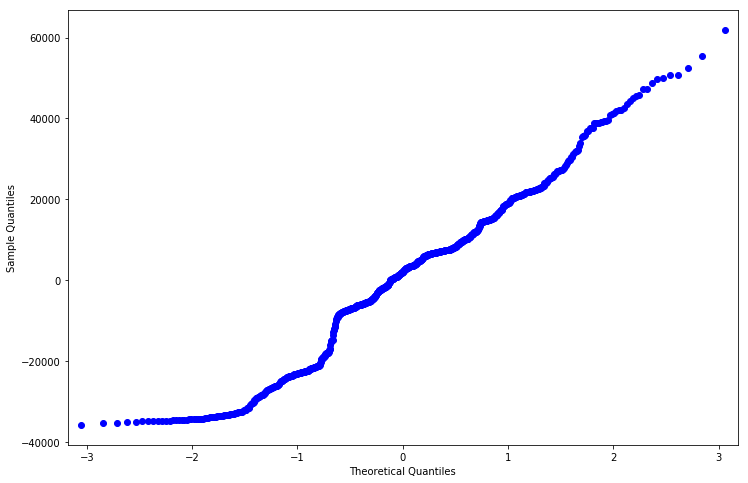

In [7]:
#In OLS, we expect residuals to follow the normal distribution with a mean of 0 and some constant variance.
#we can check for a straight line on a Q-Q plot
#not a straigh line, there are some discrepancies.
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = sm.qqplot(price_results.resid, ax=ax)

In [8]:
#lilliefors-test for the normality assumption
#p-value~0 we reject H0 says that the residual follow normality.
sm.stats.lilliefors(price_results.resid)

(0.076195977022679051, 2.43260523156377e-13)

In [9]:
#Rainbow test for linearity (the null hypothesis says that the relationship is properly modelled as linear)
sm.stats.linear_rainbow(price_results)
#p-value~0, we reject linearity. PROBLEM!!!

(17.613484939919054, 2.0016859714805673e-156)

Text(0,0.5,'residuals')

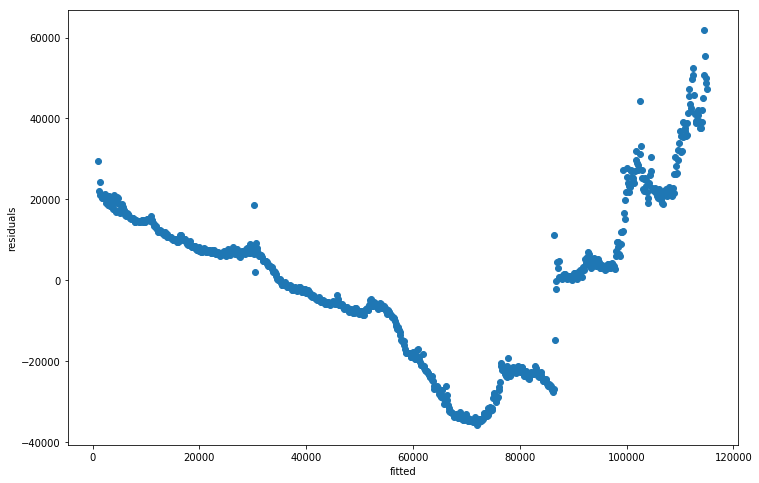

In [10]:
#Heteroscedasticity visualization
#We have problem, there is a pattern on the residuals
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(price_results.fittedvalues, price_results.resid)
ax.set_xlabel('fitted')
ax.set_ylabel('residuals')

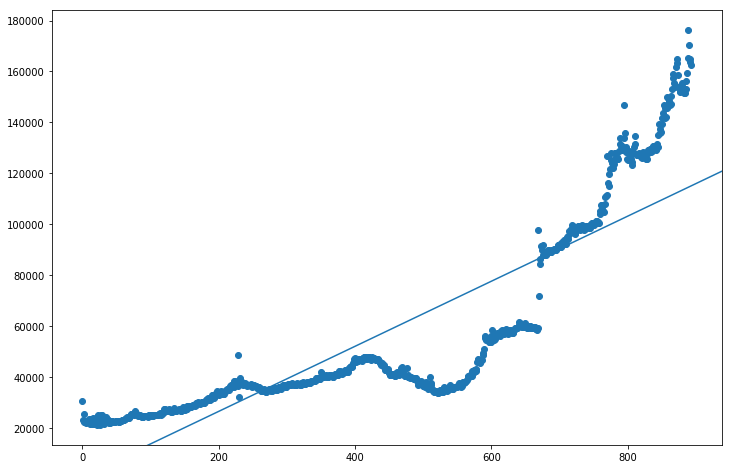

In [11]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

dates = df.increment.values
prices = df.Price.values
ax.scatter(dates, prices)
fig = sgr.regressionplots.abline_plot(model_results=price_results, ax=ax)

On the visualisation above we can observe a sharply slope starting on date ~550.(September of 2016)
This is probably the day that the new expansion released.

Before that period we observe a sligh drop on the prices, something absolutly normal because prices tend to drop before an expansion releases because player become inactive. They know that the items-gear-gold will lose their value due to inflation when the new expantion will release.

Legion released on 30/8/2016. This is the actual date that we will split our dataset.

In [12]:
df_pre_legion = df[df['increment']<510] #before legion
df_legion = df[df['increment']>509]     #30/8/2016(Legion release)

In [13]:
model_pre_legion = smf.ols("Price ~ increment", data=df_pre_legion)
price_res_pre_legion = model_pre_legion.fit()
price_res_pre_legion.params

Intercept    22360.958137
increment       46.973534
dtype: float64

In [14]:
print(price_res_pre_legion.summary(), price_res_pre_legion.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     2549.
Date:                Sat, 13 Jan 2018   Prob (F-statistic):          4.06e-200
Time:                        21:16:08   Log-Likelihood:                -4821.5
No. Observations:                 510   AIC:                             9647.
Df Residuals:                     508   BIC:                             9656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.236e+04    273.545     81.745      0.0

INTERPRETATION OF THE RESULTS

model: y = 22360.95 + 46.97*x

From the summary table we see that:
The slope and the intercept are statistically significant, which means that they are statistically different from 0.

R_square = 0.834 (Goodness of fit)
Our regression model explains 83.4% of the variability between the two variables.
Our model has been imporeved from the first model where R_square was 0,744.

Rest of the results have been explained on the first model.

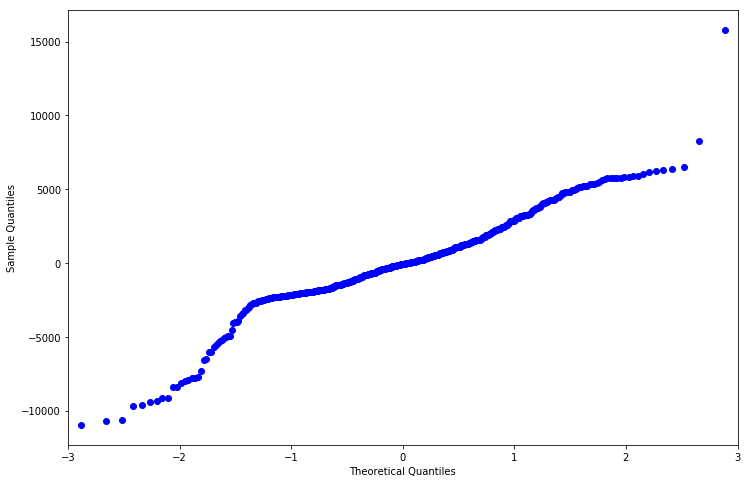

In [15]:
#Now lets evaluate our model.
#1rst: Normality of the residuals with QQplot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = sm.qqplot(price_res_pre_legion.resid, ax=ax)

In [16]:
#lilliefors-test for the normality assumption
#p-value~0 we reject H0 says that the residual follow normality.
sm.stats.lilliefors(price_res_pre_legion.resid)

(0.10874537807018697, 8.1386372577566839e-16)

In [17]:
#2nd linearity of the model
#Unfortunately, again we have to reject linearity 
sm.stats.linear_rainbow(price_res_pre_legion)

(4.2173725004735987, 1.8220535753145887e-28)

Text(0,0.5,'residuals')

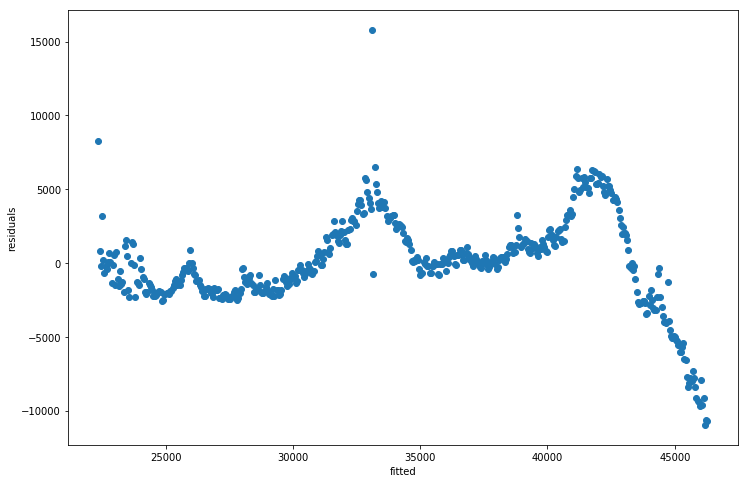

In [18]:
#3rd Heteroscedasticity visualization
#We see unambiguous pattern or trend in our residuals, our model has room for improvement.(e.g. log(Prices))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(price_res_pre_legion.fittedvalues, price_res_pre_legion.resid)
ax.set_xlabel('fitted')
ax.set_ylabel('residuals')

#George Box said: “Essentially, all models are wrong, but some are useful” :P

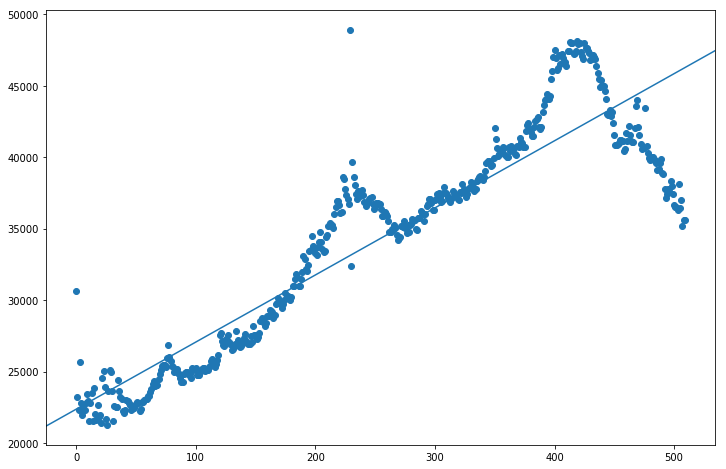

In [19]:
#Finally, we will visualise our model versus the true values to take an overall idea.
#It is obvious that this model is better than the first one.
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
dates = df_pre_legion['increment'].values
prices = df_pre_legion['Price'].values
ax.scatter(dates, prices)
fig = sgr.regressionplots.abline_plot(model_results=price_res_pre_legion, ax=ax)

In [20]:
#LEGION MODEL
model_legion = smf.ols("Price ~ increment", data=df_legion)
price_res_legion = model_legion.fit()
price_res_legion.params

Intercept   -157657.313431
increment       352.557867
dtype: float64

In [22]:
print(price_res_legion.summary(), price_res_legion.mse_resid)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.268e+04
Date:                Sat, 13 Jan 2018   Prob (F-statistic):          4.07e-295
Time:                        21:16:30   Log-Likelihood:                -3932.5
No. Observations:                 384   AIC:                             7869.
Df Residuals:                     382   BIC:                             7877.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.577e+05   2223.265    -70.913      0.0

INTERPRETATION OF THE RESULTS
model: y = -157657.31 + 352.5*x

ATTENTION! a = -157657 because our first day is 510 (independent variable will have min value = 510 *352.5)

From the summary table we see that:
The slope and the intercept are statistically significant.

R_square = 0.971 (Goodness of fit)
Our regression model explains 97.1% of the variability between the two variables.

Our model has been imporeved dramatically from the first model where R_square was 0,744.

Rest of the results have been explained on the first model so it is useless to say it again.

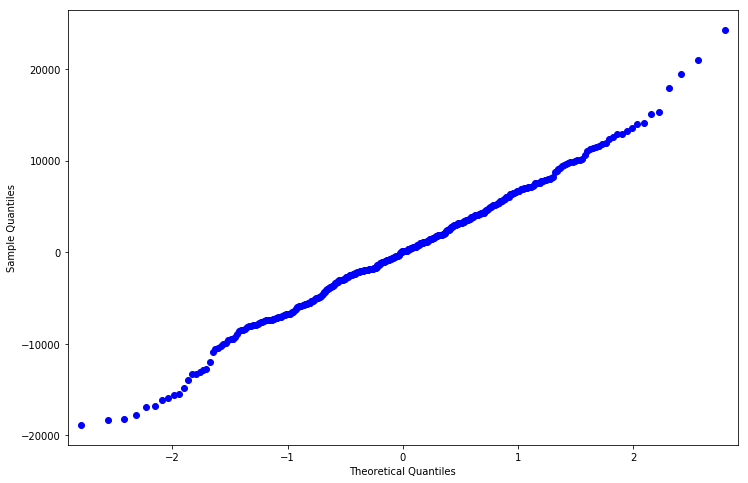

In [23]:
#MODEL EVALUATION (Normality of the residuals, Linearity, Heteroscedasticity)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = sm.qqplot(price_res_legion.resid, ax=ax)
#We can assume normality for the residuals

In [24]:
#lilliefors-test for the normality assumption
#p-value = 0.235 we do NOT reject H0 says that the residual follow normality.
sm.stats.lilliefors(price_res_legion.resid)

(0.036448066021224412, 0.23534380398852109)

In [25]:
#test for linearity of the reggresion model
sm.stats.linear_rainbow(price_res_legion)
#We do NOT REJECT linearity pv = 0.73

(0.9115984011732956, 0.73856186300595517)

Text(0,0.5,'residuals')

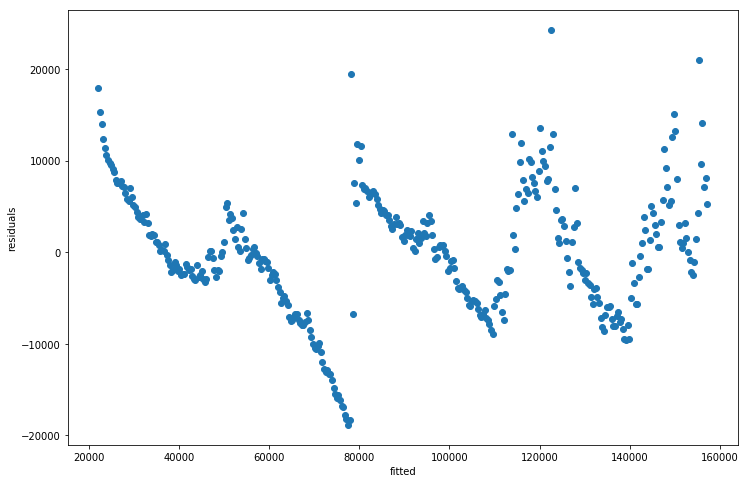

In [26]:
#Heteroscedasticity visualization
#Again we detect a clear pattern or trend in our residuals but it is much better than others' heteroscedasticity plots
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(price_res_legion.fittedvalues, price_res_legion.resid)
ax.set_xlabel('fitted')
ax.set_ylabel('residuals')

All in all the SLR after the expansion has been released fulfill almost all the assumption.

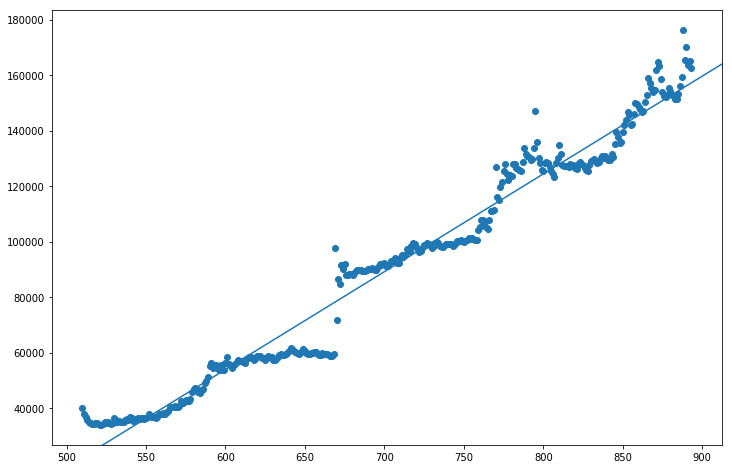

In [27]:
#visualisation of the model. It is obvious that we have a good model this time, true values fluctuate close to the predicted values
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
dates = df_legion['increment'].values
prices = df_legion['Price'].values
ax.scatter(dates, prices)
fig = sgr.regressionplots.abline_plot(model_results=price_res_legion, ax=ax)

To sum up, when we split the data into two periods(pre-legion and after-legion) we have much better and valid models.

Finally, we will try Time Series just to show the case, according to the lecture slide. 

In [46]:
#df = df.set_index('Date')
df_ts = df.set_index('increment').copy()
price_cycle, price_trend = sm.tsa.filters.hpfilter(df.Price)

In [47]:
price_decomp = df[['Price']].copy()
price_decomp['trend'] = price_trend
price_decomp['cycle'] = price_cycle

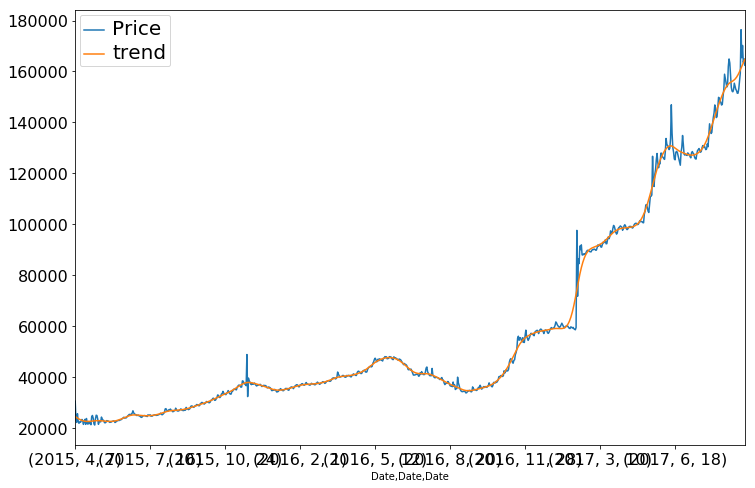

In [56]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
price_decomp[['Price', 'trend']].plot(ax=ax, fontsize=16)
legend = ax.get_legend()
legend.prop.set_size(20)

As we can see from the plot above TS is better solution to predict prices when you have as an independent variable Dates